# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) and pandas. 
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: *** 319091039 - 318339041***

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

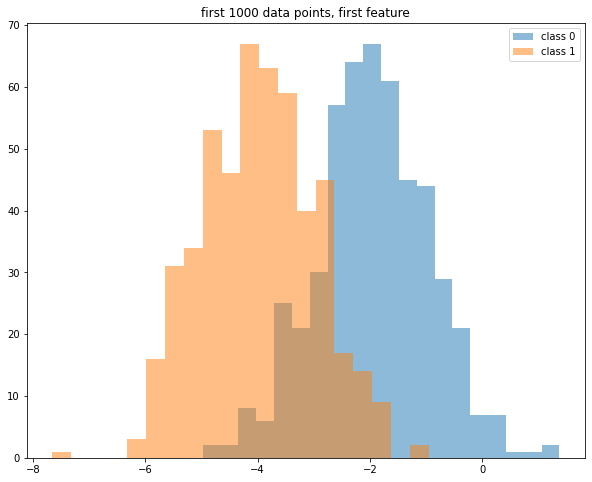

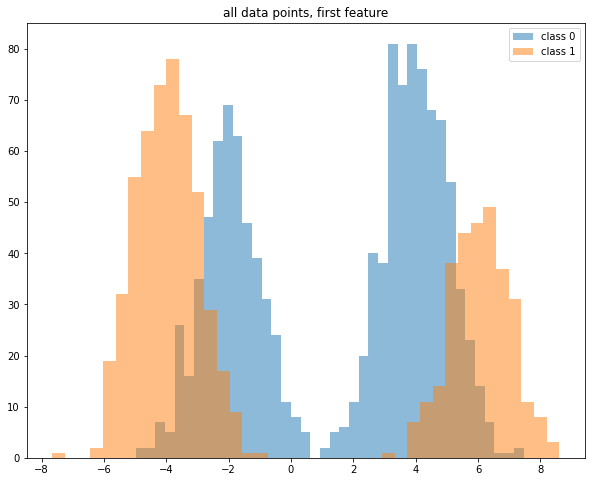

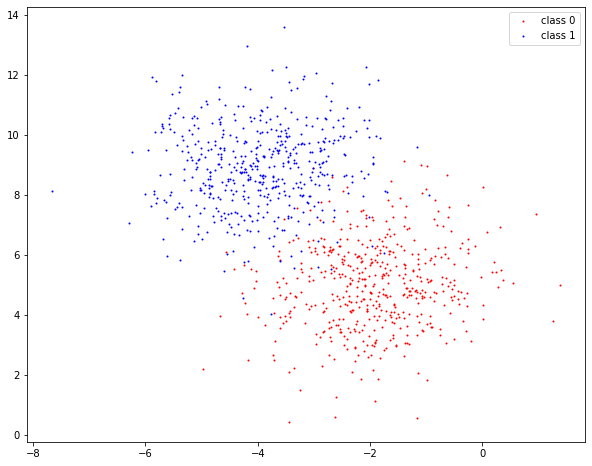

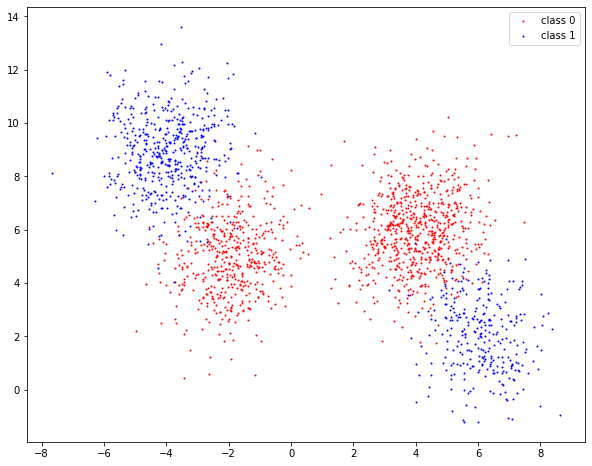

In [4]:
#### Your code here ####
rows = training_set.head(1000)
class0_rows = rows.loc[rows['y'] == 0]
class1_rows = rows.loc[rows['y'] == 1]
class0_row = class0_rows['x1']
class1_row = class1_rows['x1']
plt.hist(class0_row, bins = 20, alpha = 0.5, label='class 0')
plt.hist(class1_row, bins = 20, alpha = 0.5, label = 'class 1')
plt.legend()
plt.title('first 1000 data points, first feature')
plt.show()

class0_rows = training_set.loc[training_set['y'] == 0]
class1_rows = training_set.loc[training_set['y'] == 1]
class0_row = class0_rows['x1']
class1_row = class1_rows['x1']
plt.hist(class0_row, bins = 40, alpha = 0.5, label='class 0')
plt.hist(class1_row, bins = 40, alpha = 0.5, label = 'class 1')
plt.legend()
plt.title('all data points, first feature')
plt.show()

rows0 = rows.loc[rows['y']==0]
rows1 = rows.loc[rows['y']==1]
plt.scatter(rows0['x1'], rows0['x2'], s = 1 , c = 'r', label ='class 0' )
plt.scatter(rows1['x1'], rows1['x2'], s = 1 , c = 'b', label ='class 1' )
plt.legend()
plt.show()

rows0 = training_set.loc[training_set['y']==0]
rows1 = training_set.loc[training_set['y']==1]
plt.scatter(rows0['x1'], rows0['x2'], s = 1 , c = 'r', label ='class 0' )
plt.scatter(rows1['x1'], rows1['x2'], s = 1 , c = 'b', label ='class 1' )
plt.legend()
plt.show()

## Logistic Regression

(15 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [7]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
        
    def compute_cost(self, X, y, theta):
        #print(X)
        m = len(y)
        h = self.sigmoid(X @ theta)
        epsilon = 1e-5
        cost = (1/m)*((-y @ np.log(h))-((1-y) @ np.log(1-h)))
        #print(cost)
        return cost

    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        np.random.seed(self.random_state)
        theta = np.random.random(size=X.shape[1])
        m = X.shape[1]
        costs = []
        for i in range(self.n_iter):
            h_theta_minus_y = self.sigmoid(X @ theta) - y
            costs.append(self.compute_cost(X,y,theta))
            new_theta = theta - self.eta*X.T.dot(h_theta_minus_y)/m
            if i>2:    
                if(costs[-2] - costs[-1] < self.eps):
                    theta = new_theta
                    break
            theta = new_theta
        self.costs = costs
        self.theta = theta
    
    def predict(self, X):
        """Return the predicted class label"""
        X_ones = np.column_stack((np.ones(len(X)),X)) 
        return np.round(self.sigmoid(X_ones @ self.theta))
    
    def calc_accuracy(self, data):
        feature = data[:, :-1]
        label = data[:,-1]
        predict = self.predict(feature)
        return np.sum(predict==label)/label.size
        
        
    

## Cross Validation

(5 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [8]:
#### Your code here ####
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

def split_val(X,i):
    len = X.shape[0]
    validation = X[len*(i-1)//5:len*i//5]
    train =np.row_stack((X[0:len*(i-1)//5],X[len*i//5:len]))
    #print("in split: ", i, " validation shape: ", validation.shape, " train shape: ", train.shape)
    return train, validation

def cross_val(X,eta,eps):
    sum = 0 
    all = 0
    class_log = LogisticRegressionGD(eta = eta, eps= eps)
    for i in range(1,6):   
        train, validtion = split_val(X,i)
        class_log.fit(train[:, :-1],train[:,-1])
        
        return class_log.calc_accuracy(validtion[:,1:])
    """     for row in validtion:
            row[1:-1][None,:]
            if class_log.predict(row[1:-1][None,:]) == row[-1]:
                sum += 1
            all += 1
    return sum/all
    """

X = training_set.values
X = np.column_stack((np.ones(len(X)),X))
np.random.shuffle(X)
best_val = 0
best_eta = 0
best_eps = 0
for eta in etas:
    for eps in epss:
        temp = cross_val(X,eta,eps)
        print("accuracy for eps: ", eps, ", eta: ", eta, " is : ", temp)
        if temp > best_val:
            best_val = temp
            best_eta = eta
            best_eps = eps
print("the best eps is:", best_eps, "and the best eta is:", best_eta,"the best accuracy is:", best_val)

accuracy for eps:  0.01 , eta:  0.05  is :  0.5875
accuracy for eps:  0.001 , eta:  0.05  is :  0.5875
accuracy for eps:  0.0001 , eta:  0.05  is :  0.5875
accuracy for eps:  1e-05 , eta:  0.05  is :  0.5875
accuracy for eps:  1e-06 , eta:  0.05  is :  0.5875
accuracy for eps:  0.01 , eta:  0.005  is :  0.3775
accuracy for eps:  0.001 , eta:  0.005  is :  0.3775
accuracy for eps:  0.0001 , eta:  0.005  is :  0.3775
accuracy for eps:  1e-05 , eta:  0.005  is :  0.3775
accuracy for eps:  1e-06 , eta:  0.005  is :  0.3775
accuracy for eps:  0.01 , eta:  0.0005  is :  0.5475
accuracy for eps:  0.001 , eta:  0.0005  is :  0.5475
accuracy for eps:  0.0001 , eta:  0.0005  is :  0.555
accuracy for eps:  1e-05 , eta:  0.0005  is :  0.5475
accuracy for eps:  1e-06 , eta:  0.0005  is :  0.5475
accuracy for eps:  0.01 , eta:  5e-05  is :  0.5575
accuracy for eps:  0.001 , eta:  5e-05  is :  0.53
accuracy for eps:  0.0001 , eta:  5e-05  is :  0.545
accuracy for eps:  1e-05 , eta:  5e-05  is :  0.58

## Normal distribution pdf

(2 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [18]:
#### Your code here ####
# calc normal pdf
def norm_pdf(data, mu, sigma):
    prob_density = np.exp(-0.5*((data-mu)/sigma)**2)/(np.sqrt(np.pi*2)*sigma)
    return prob_density 

## Expectation Maximization

(15 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [19]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps

    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        np.random.seed(42)
        ones = np.ones(self.k)
        self.mu, self.sigma, self.w = np.random.choice(data, self.k, replace=False), ones, ones/self.k
        
    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        self.r = self.w[None,:] * norm_pdf(data[:,None], self.mu[None,:], self.sigma[None,:])
        self.r = self.r / self.r.sum(axis = 1, keepdims = True)
        


    def maximization(self, data):
        """
        M step - updating distribution params
        """
        N = data.shape[0]
        self.w = np.mean(self.r, axis = 0) 
        self.mu = (data @ self.r) / (N * self.w) 
        self.sigma = np.sqrt(np.diag(((data[None,:] - self.mu[:,None])**2 @ self.r)) / (N * self.w))

        
        

        
    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        self.init_params(data)
        prev_cost = self.cost(data)
        for i in range(self.n_iter):
            self.expectation(data)
            self.maximization(data)
            curr_cost = self.cost(data)
            if abs(prev_cost - curr_cost) < self.eps:
                break
            prev_cost = curr_cost 
    
    def cost(self,data):
        temp = norm_pdf(data[:,None],self.mu[None,:],self.sigma[None,:]) @ self.w
        #temp = np.array([norm_pdf(data, self.mu[j], self.sigma[j]) for j in range(self.k)]).T @ self.w
        cost = np.sum(-np.log(temp))
        return cost   

    def get_dist_params(self):
        return self.mu, self.sigma, self.w



## Naive Bayes

(15 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [20]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1):
        self.k = k

    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        param = np.zeros(dtype=[('w','f4'),('mu','f4'),('sigma','f4')], shape=(2,X.shape[1],self.k))
        
        self.prior = np.array([np.sum(y==0), np.sum(y==1) ]) / y.size
        for i,coloumn in enumerate(X.T):
            for j in range(2):
                EM_obj = EM(k = self.k)
                data = coloumn[y==j]
                EM_obj.fit(data)
                param['mu'][j,i,:], param['sigma'][j,i,:], param['w'][j,i,:] = EM_obj.get_dist_params()
            
        self.param = param   
            
        
    def likelihood(self, x, label):
        likelihood = np.ones(x.shape[0])
        for i, feature in enumerate(x.T):
            likelihood *=  norm_pdf(feature[:,None], self.param['mu'][label,i,:][None,:], self.param['sigma'][label,i,:][None,:]) @ self.param['w'][label,i,:]
        return likelihood
            
        
    
    
    def predict(self, X):
        """Return the predicted class label"""
        
        
        prob = np.zeros((X.shape[0],2))
        for i in range(2):
            prob[:,i] = self.prior[i] * self.likelihood(X, i)
        return np.argmax(prob, axis=1)
    
    def calc_accuracy(self, data):
        feature = data[:, :-1]
        label = data[:,-1]
        predict = self.predict(feature)
        #predict = np.array([self.predict(row) for row in feature])
        return np.sum(predict==label)/label.size

        


## Model evaluation

(20 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

first 1000 samples logistic regression train accuracy:  0.96
first 1000 samples logistic regression test accuracy:  0.94
first 1000 samples naive bayes train accuracy:  0.966
first 1000 samples naive bayes test accuracy:  0.942
all samples logistic regression train accuracy:  0.7885
all samples logistic regression test accuracy:  0.78
all samples naive bayes train accuracy:  0.9215
all samples naive bayes test accuracy:  0.902


Text(0, 0.5, 'cost')

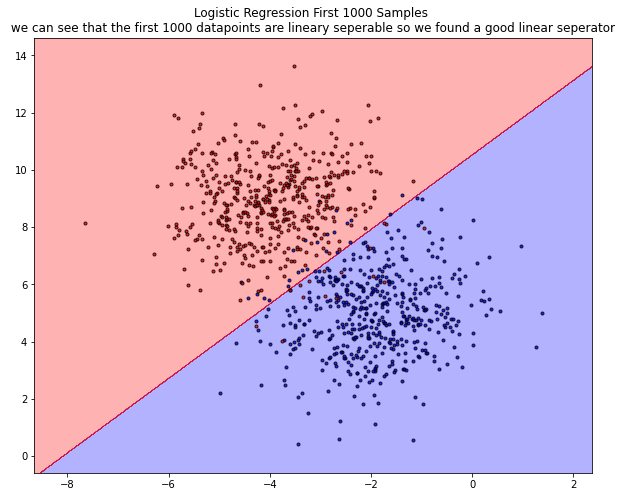

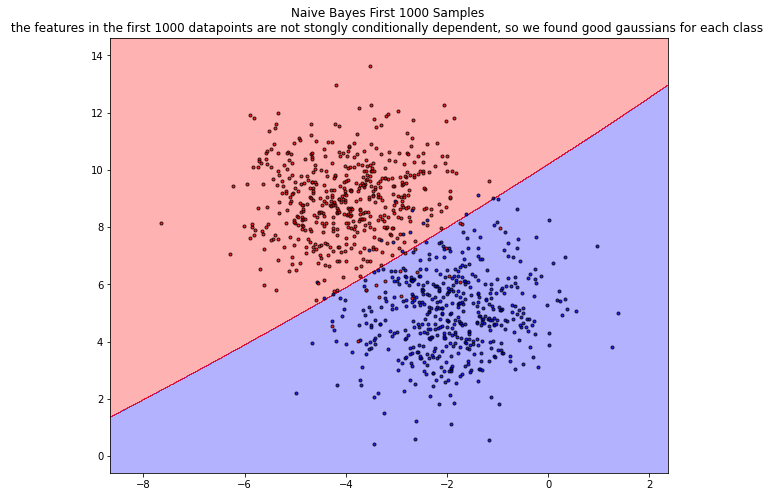

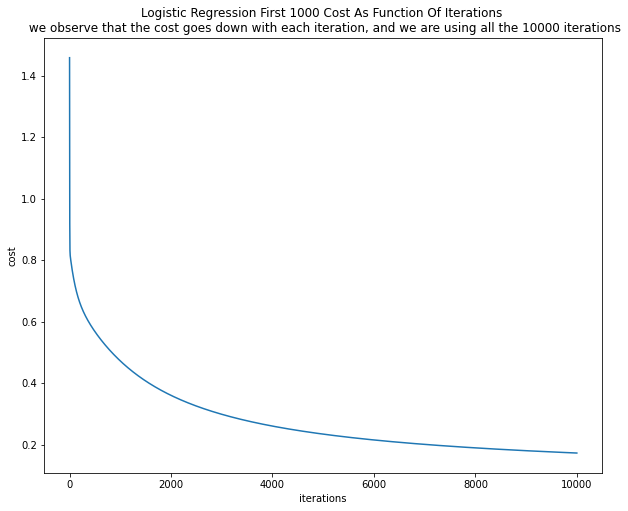

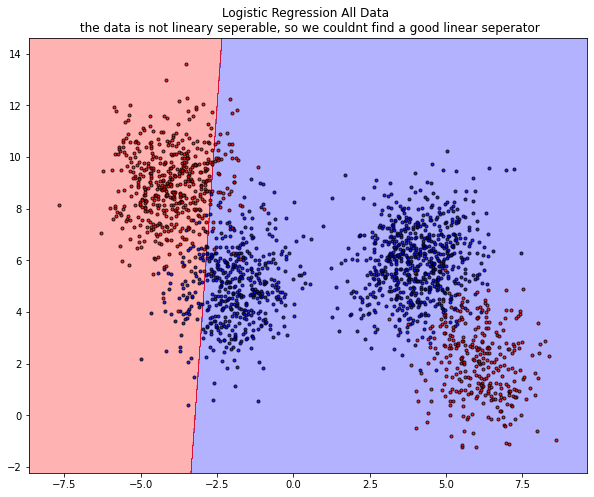

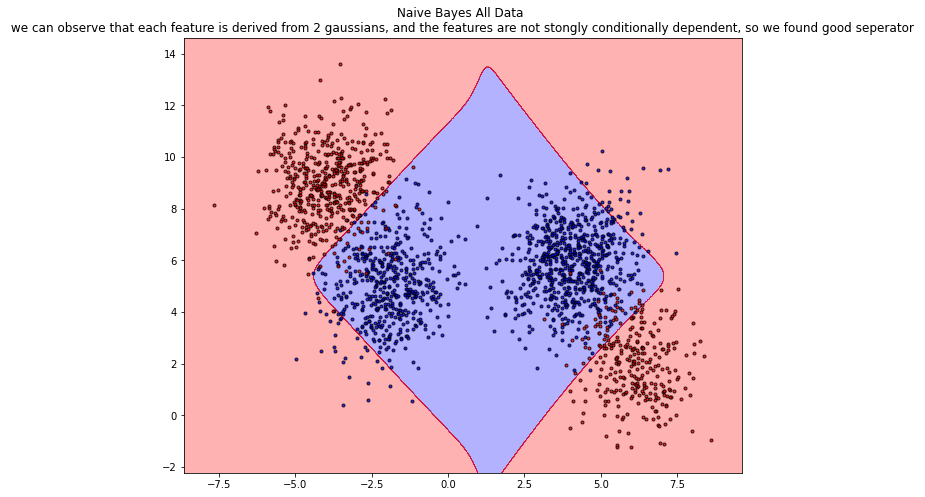

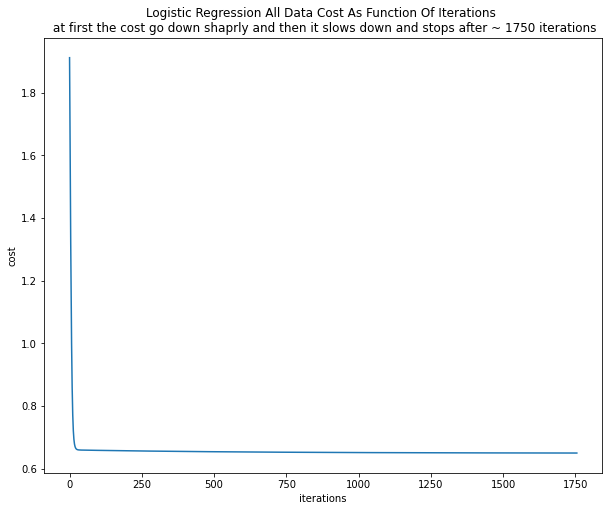

In [21]:
##first 1000 samples##

first_1000_train = training_set.head(1000).to_numpy()
first_1000_test = test_set.head(500).to_numpy()
X = first_1000_train[:, :-1]
y = first_1000_train[:,-1]
X_ones = np.column_stack((np.ones(len(X)),X))
first_1000_regression = LogisticRegressionGD(eta = 5e-05, eps= 1e-06)
first_1000_regression.fit(X_ones,y)
first_1000_bayes = NaiveBayesGaussian(k=1)
first_1000_bayes.fit(X,y)
print("first 1000 samples logistic regression train accuracy: ",first_1000_regression.calc_accuracy(first_1000_train))
print("first 1000 samples logistic regression test accuracy: ",first_1000_regression.calc_accuracy(first_1000_test))
print("first 1000 samples naive bayes train accuracy: ",first_1000_bayes.calc_accuracy(first_1000_train))
print("first 1000 samples naive bayes test accuracy: ",first_1000_bayes.calc_accuracy(first_1000_test))
plt.figure(); plot_decision_regions(X, y, first_1000_regression)
plt.title("Logistic Regression First 1000 Samples \n we can see that the first 1000 datapoints are lineary seperable so we found a good linear seperator ")
plt.figure(); plot_decision_regions(X, y, first_1000_bayes)
plt.title("Naive Bayes First 1000 Samples \n the features in the first 1000 datapoints are not stongly conditionally dependent, so we found good gaussians for each class  ")
plt.figure() ; plt.plot(np.arange(len(first_1000_regression.costs)), first_1000_regression.costs)
plt.title("Logistic Regression First 1000 Cost As Function Of Iterations \n we observe that the cost goes down with each iteration, and we are using all the 10000 iterations")
plt.xlabel("iterations")
plt.ylabel("cost")



##all data##

train_data = training_set.to_numpy()
test_data = test_set.to_numpy()
X = train_data[:, :-1]
y = train_data[:,-1]
all_data_regression = LogisticRegressionGD(eta = 5e-05, eps= 1e-06)
all_data_regression.fit(np.column_stack((np.ones(len(X)),X)),y)
all_data_bayes = NaiveBayesGaussian(k=2)
all_data_bayes.fit(X,y)
print("all samples logistic regression train accuracy: ",all_data_regression.calc_accuracy(train_data))
print("all samples logistic regression test accuracy: ",all_data_regression.calc_accuracy(test_data))
print("all samples naive bayes train accuracy: ",all_data_bayes.calc_accuracy(train_data))
print("all samples naive bayes test accuracy: ",all_data_bayes.calc_accuracy(test_data))
plt.figure(); plot_decision_regions(X, y, all_data_regression)
plt.title("Logistic Regression All Data \n the data is not lineary seperable, so we couldnt find a good linear seperator")
plt.figure(); plot_decision_regions(X, y, all_data_bayes)
plt.title("Naive Bayes All Data \n we can observe that each feature is derived from 2 gaussians, and the features are not stongly conditionally dependent, so we found good seperator ")
plt.figure() ; plt.plot(np.arange(len(all_data_regression.costs)), all_data_regression.costs)
plt.title("Logistic Regression All Data Cost As Function Of Iterations \n at first the cost go down shaprly and then it slows down and stops after ~ 1750 iterations")
plt.xlabel("iterations")
plt.ylabel("cost")


## Open question

(20 points) 

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
   1. Generate a dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Naive Bayes will work better than Logisitc Regression**.
   2. Generate another dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Logistic Regression will work better than Naive Bayes**.
   
   - Explain the reasoning behind each dataset.  

2. Visualize the datasets.  
   You can choose one of two options for the visualization:
    1. Plot three 2d graphs of all the features against each other (feature1 vs feature2, feature1 vs feature3, feature2 vs feature3).
    2. Plot one 3d graph.

**Important Note**  
For this question only, you may use:  
```
from scipy.stats import multivariate_normal
```

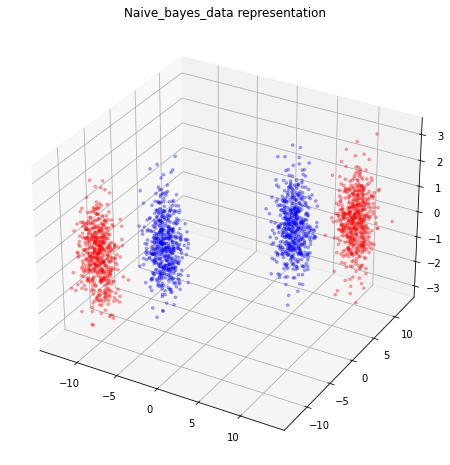

my naive_bayes_data logistic regression accuracy:  0.4995
my naive_bayes_data naive bayes accuracy:  1.0


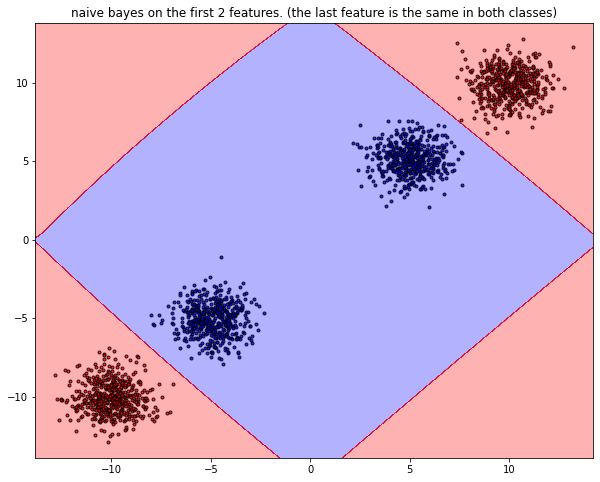

my logistic_data logistic regression accuracy:  0.8645
my logistic_data naive bayes accuracy:  0.684


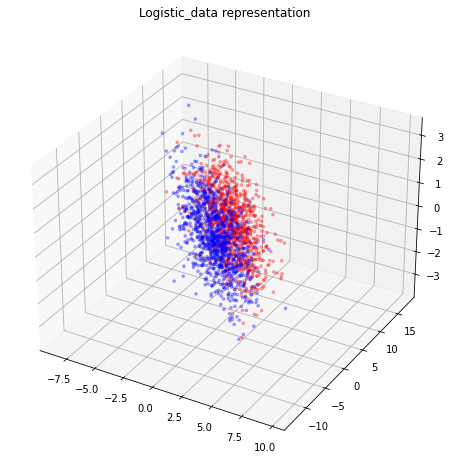

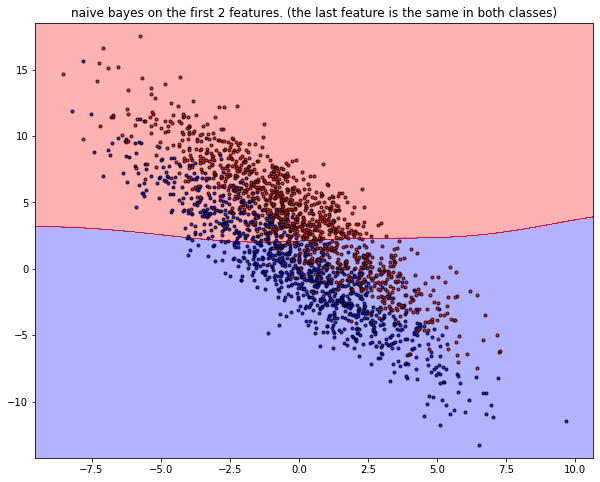

In [22]:

naive_bayes_data = np.zeros(shape=(2000,5))
naive_bayes_data[:,0] = np.ones(2000)
naive_bayes_data[:,1:4] = np.random.normal(0, 1 , [2000,3])
naive_bayes_data[:500,1] += 5
naive_bayes_data[500:1000,1] -= 5
naive_bayes_data[1000:1500,1] += 10
naive_bayes_data[1500:2000,1] -= 10
naive_bayes_data[:500,2] += 5
naive_bayes_data[500:1000,2] -= 5
naive_bayes_data[1000:1500,2] += 10
naive_bayes_data[1500:2000,2] -= 10
naive_bayes_data[1000:,-1] = np.ones(shape = (1000,))


ax = plt.axes(projection='3d')

plt.title("Naive_bayes_data representation")
ax.scatter3D(naive_bayes_data[:1000,1], naive_bayes_data[:1000,2],naive_bayes_data[:1000,3],c= 'b', alpha = 0.3, s= 7)
ax.scatter3D(naive_bayes_data[1000:,1], naive_bayes_data[1000:,2], naive_bayes_data[1000:,3],c= 'r', alpha = 0.3, s= 7)
plt.show()
np.random.shuffle(naive_bayes_data)
logistic_regression = LogisticRegressionGD(eta = 5e-02, eps= 1e-06)
logistic_regression.fit(naive_bayes_data[:,:-1], naive_bayes_data[:,-1])
naive = NaiveBayesGaussian(k=2)
naive.fit(naive_bayes_data[:,1:-1], naive_bayes_data[:,-1])

print("my naive_bayes_data logistic regression accuracy: " ,logistic_regression.calc_accuracy(naive_bayes_data[:,1:]))
print("my naive_bayes_data naive bayes accuracy: " ,naive.calc_accuracy(naive_bayes_data[:,1:]))

naive_check = NaiveBayesGaussian(k=2)
naive_check.fit(naive_bayes_data[:,1:3], naive_bayes_data[:,-1])

plt.figure(); plt.title("naive bayes on the first 2 features. (the last feature is the same in both classes)")
plot_decision_regions(naive_bayes_data[:,1:3], naive_bayes_data[:,-1], naive_check)
plt.show()


























logistic_data = np.zeros(shape = (2000,5))
logistic_data[:,0] = np.ones(2000)
logistic_data[:1000,1] = np.random.normal(0, 5 , 1000)
logistic_data[:1000,2] = np.random.normal(0, 1 , 1000)
logistic_data[:1000,3] = np.random.normal(0, 1 , 1000)
rotation_matrix = np.array([[np.cos(45), -np.sin(45)],
                           [np.sin(45), np.cos(45)]])

logistic_data[1000:,1] = np.random.normal(0, 5 , 1000)
logistic_data[1000:,2] = np.random.normal(0, 1 , 1000)
logistic_data[1000:,3] = np.random.normal(0, 1 , 1000)
logistic_data[1000:,4] = np.ones(shape = (1000,))
logistic_data[:,1:3] = logistic_data[:,1:3] @ rotation_matrix
logistic_data[1000:,2] += 4
ax = plt.axes(projection='3d')

plt.title("Logistic_data representation")
ax.scatter3D(logistic_data[:1000,1], logistic_data[:1000,2], logistic_data[:1000,3],c= 'b', alpha = 0.3, s= 7)
ax.scatter3D(logistic_data[1000:,1], logistic_data[1000:,2], logistic_data[1000:,3],c= 'r', alpha = 0.3, s= 7)
np.random.shuffle(logistic_data)
logistic_regression = LogisticRegressionGD(eta = 5e-05, eps= 1e-06)
logistic_regression.fit(logistic_data[:,:-1], logistic_data[:,-1])
naive = NaiveBayesGaussian(k=1)
naive.fit(logistic_data[:,1:-1], logistic_data[:,-1])

print("my logistic_data logistic regression accuracy: " ,logistic_regression.calc_accuracy(logistic_data[:,1:]))
print("my logistic_data naive bayes accuracy: " ,naive.calc_accuracy(logistic_data[:,1:]))

naive_check = NaiveBayesGaussian(k=2)
naive_check.fit(logistic_data[:,1:3], logistic_data[:,-1])

plt.figure(); plt.title("naive bayes on the first 2 features. (the last feature is the same in both classes)")
plot_decision_regions(logistic_data[:,1:3], logistic_data[:,-1], naive_check)
plt.show()




# data explenations:
 
**naive_data** : we chose a data set that is not lineary seperable, but can be seperated by naive bayes with EM.

**logistic_data** : we chose a data where x1 and x2 (first and second features) are strongly conditinally dependent, and is        lineary seperable.
so the logistic regression found a good seperator, but the naive bayes failed.
 